In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import calendar

from sklearn.preprocessing import PolynomialFeatures
from collections import Counter, defaultdict
from sklearn.metrics import roc_curve, auc
from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

In [2]:
dataset = pd.read_csv('network_backup_dataset.csv')
dataset = dataset.drop(['Backup Time (hour)'],axis=1)

In [3]:
def getX_Y_from_dataset(dataset):
    Y = (dataset['Size of Backup (GB)'].as_matrix())
    X = dataset.drop(['Size of Backup (GB)'],axis=1)
    return X,Y

In [4]:
def encode_day_names(days):
    day_to_num = dict(zip(list(calendar.day_name), range(1, 8)))
    return [day_to_num[day] for day in days]
def encode_datalist(datalist):
    encoding = {}
    for i in datalist:
        if i in encoding:
            continue
        else:
            encoding[i] = i.split('_')[-1]
    return [encoding[i] for i in datalist]
def scalar_encode(dataset):
    dataset_copy = dataset.copy()
    # dataset_copy contains scalar encoding of features
    dataset_copy['Day of Week'] = encode_day_names(dataset_copy['Day of Week'])
    dataset_copy['File Name'] = encode_datalist(dataset_copy['File Name'])
    dataset_copy['Work-Flow-ID'] = encode_datalist(dataset_copy['Work-Flow-ID'])
    return dataset_copy

    
def one_hot_encode(dataset):
    dataset_cat = dataset.select_dtypes(include=[object])
    dataset_cat = scalar_encode(dataset_cat)
    oh_enc = preprocessing.OneHotEncoder()
    oh_enc.fit(dataset_cat)
    onehotlabels = oh_enc.transform(dataset_cat)
    cat_array = onehotlabels.toarray()
    dataset_no_cat = dataset.select_dtypes(exclude=[object])
    non_cat_array = dataset_no_cat.as_matrix()
    return np.concatenate((non_cat_array,cat_array),axis = 1)
    

In [5]:
def perform_10fold(X,y,regressor):
    kf = KFold(n_splits=10,shuffle = True,random_state = 42)
    i = 1
    bestModel = None
    tr_e = 0
    ts_e = 0
    min_ts_e = 10
    for train_index, test_index in kf.split(X):
        #print("Fold : ",i)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        regressor.fit(X_train,y_train)
        train_preds = regressor.predict(X_train)
        test_preds = regressor.predict(X_test)
        test_error = mean_squared_error(y_test,test_preds)
        tr_e += mean_squared_error(y_train,train_preds)
        ts_e += test_error
        if(test_error<min_ts_e):
            min_ts_e = test_error
            bestModel = regressor
        i = i+1
    return np.sqrt(tr_e/10),np.sqrt(ts_e/10), bestModel

In [6]:
X,Y= getX_Y_from_dataset(dataset)

In [7]:
X =one_hot_encode(X)

In [8]:
def analyse_nn_regressor(layers,max_layer_size,interval):
    train_map = defaultdict(list)
    test_map = defaultdict(list)
    for activation_ in ['identity', 'logistic', 'tanh', 'relu']:
        print('activation function:',activation_)
        for hidden_size in range(1,max_layer_size,interval):
            mlp_reg = MLPRegressor(hidden_layer_sizes=tuple([hidden_size]*layers),activation=activation_,random_state=1)
            train_rmses,test_rmses,m=perform_10fold(X,Y,mlp_reg)
            print(train_rmses,test_rmses)
            train_map[activation_].append(train_rmses)
            test_map[activation_].append(test_rmses)
    for algo in test_map:
        plt.plot(range(1,max_layer_size,interval),test_map[algo], label = algo, marker='.',markersize=4)
    plt.title('Neural Network Regression Performance | size : layers ='+str(layers))
    plt.xlabel('Size of each layer')
    plt.ylabel('Test RMSE')
    plt.legend()
    plt.show()
            

activation function: identity
0.0898448566956 0.0900431661475
0.0899262903226 0.0901458635176
0.0902705817951 0.0904654536543
0.0898210283725 0.0899923300898
0.089881983097 0.0900418516429
0.0898582151076 0.0900491691642
0.0898109598505 0.0899770914158
0.0898005481209 0.0899501930242
0.0914173733706 0.0914318256165
0.0898579748263 0.0900766975813
0.090226977646 0.0905892797625
0.089894212014 0.0900831687463
0.0899775829023 0.0901441386472
0.0898213203609 0.0900056322279
0.0898601015215 0.090057193675
0.0910669889099 0.0914484699867
0.0898269074348 0.0900363512197
0.0898380999907 0.0900067341256
0.0899394485891 0.0901395317742
0.0899846039196 0.0902938456629
0.0899802182389 0.0901558619676
0.089886550868 0.0901116020153
0.089962610626 0.0902204237087
0.0899814248502 0.0900930237614
0.08990801531 0.0902364562565
0.0898683779741 0.0900266596789
0.0898616405251 0.0900273491634
0.0899027741122 0.0900942510256
0.0907097472562 0.0909059186062
0.0901339558172 0.0904156220144
0.0900040619268 0.

0.0516370032147 0.0531586137543
0.049743430599 0.05109536252
0.0499887170704 0.0513525931248
0.0507176305718 0.0520158074968
0.0508568445424 0.0520027485862
0.083364902813 0.0841816120803
0.050770575578 0.0524172036338
0.0513833825679 0.052635276511
0.0779654266198 0.0801611453748
0.0515419535873 0.0528729365213
0.0514600027786 0.0527744946127
0.0746716837128 0.0766382385089
0.0840287174528 0.0848134269118
0.0502494943653 0.0515657390736
0.0531603412334 0.0544393390046
0.0522754092055 0.0537868344231
0.0510333782633 0.0523130694054
0.0516866683845 0.0530992478404
0.0513639736752 0.0524641064686
0.0500962996429 0.0516479409999
0.0506256849448 0.0518371798396
0.0526431534717 0.053963964991
0.052008629036 0.0533866666858
0.083227321755 0.0841375136779
0.0511250712341 0.0523676841187
0.0653408348285 0.0657366634803
0.0512857306628 0.0523165465287
0.0515819020009 0.0528165179556
0.0507450961229 0.0517779336301
0.053177827595 0.0542922291869
0.0808581866453 0.0814965563946
0.0529432060674 0.

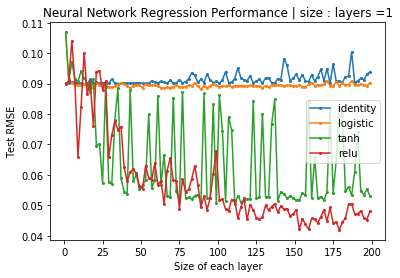

In [9]:
analyse_nn_regressor(1,200,2)

activation function: identity
0.102332192398 0.102387655776
0.0900027440812 0.090186109878
0.0906868060256 0.0908434807783
0.0899609475251 0.0900926368156
0.0899008959318 0.0900403138125
0.0901021604238 0.0903317460345
0.0899621278988 0.0901049218912
0.0898677494196 0.0901025011561
0.0907030525529 0.0910084967482
0.0908108225495 0.0911807316872
0.090075821279 0.0902761893208
0.0899754230934 0.0902134294246
0.0913363997159 0.09176583531
0.0903132922196 0.0904934497269
0.0899936908905 0.0902985989371
0.0903289641312 0.0904848777464
0.0902620508986 0.0905275283537
0.0900743679232 0.0903154709071
0.0899931824578 0.0901959875998
0.0900476872735 0.090078269185
0.0926259853645 0.0931876246077
0.0962340919453 0.0964618656629
0.0948699150885 0.0948701915835
0.0914406886086 0.0913635323238
0.0900598183233 0.0901621549658
0.0910147302481 0.0912115120743
0.0975520420526 0.0981400433609
0.0916252522209 0.0920427333009
0.0925900050701 0.0927132172637
0.0904960174821 0.090733478346
0.0905636409691 0.

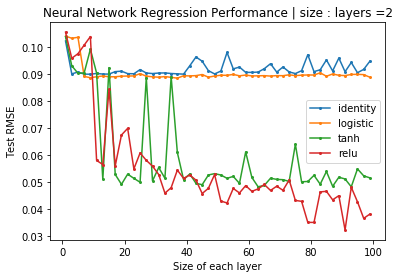

In [10]:
analyse_nn_regressor(2,100,2)

activation function: identity
0.103734461615 0.103739064471
0.0901823794571 0.0903165467939
0.0900294876796 0.0903214904076
0.0899316139626 0.0901378093514
0.090550521326 0.0908604699456
0.090291945475 0.0905519814679
0.0901213921014 0.0902191374593
0.0914250529254 0.0917051264488
0.090165841839 0.0903260428434
0.0900043033847 0.090207464851
0.0898869079949 0.0900160655316
0.0900185139627 0.0901735701546
0.0905378233085 0.0909565359707
0.0906394879825 0.0907446478983
0.0913460354028 0.0914767545815
0.0938621846784 0.0941869052466
0.0904774646649 0.0905260626571
0.0935302900184 0.0935023796003
0.092580156357 0.0928543225347
0.090689389776 0.0907685920733
0.0919751269062 0.0923808031401
0.0929388083536 0.0929852963897
0.0900072123655 0.0901415048693
0.0961145355643 0.0962917364351
0.0931215548246 0.093376574329
activation function: logistic
0.104425597037 0.104429874802
0.0875605708483 0.0876712976169
0.104056864539 0.104063372675
0.102186283698 0.102196085967
0.087426603882 0.0875977351

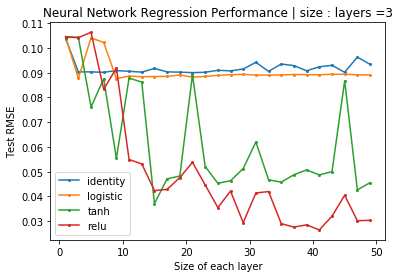

In [11]:
analyse_nn_regressor(3,50,2)

activation function: identity
0.100264693535 0.100300944148
0.0899215302359 0.0901760284318
0.0904737764344 0.090604469253
0.0902751905545 0.0906051459613
0.0901238755529 0.0903674643061
0.08994806234 0.0901661890735
0.0900745604162 0.0902006133419
0.0903995024208 0.0905715592028
0.0903786354648 0.0906280721722
0.0901998845225 0.090218291765
activation function: logistic
0.104189511422 0.104193889915
0.104187503514 0.10419216948
0.104131158323 0.104138659254
0.104180510259 0.104174408317
0.10415851578 0.104151647772
0.104061728638 0.104037239784
0.104145669065 0.104138959803
0.103701569275 0.103749240995
0.103996330508 0.103998433668
0.10394736903 0.103961523354
activation function: tanh
0.104179273 0.104184258497
0.0935339037512 0.0937002145308
0.104020499925 0.104085600151
0.0545659134694 0.0547733683319
0.0560938996513 0.0572140359391
0.070381509503 0.0735172855072
0.0861492204908 0.0864690240328
0.0723695320919 0.0737562791674
0.0858157345233 0.0864041061465
0.0299732720243 0.03141

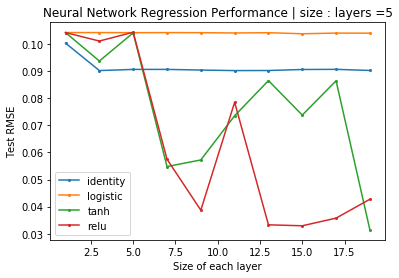

In [12]:
analyse_nn_regressor(5,20,2)

## KNN

In [13]:
dataset.columns

Index(['Week #', 'Day of Week', 'Backup Start Time - Hour of Day',
       'Work-Flow-ID', 'File Name', 'Size of Backup (GB)'],
      dtype='object')

In [14]:
def analyze_knn(neighbor_range,remove_cols=[]):
    removed_data = dataset.drop(remove_cols,axis=1)
    X_r,Y_r = getX_Y_from_dataset(removed_data)
    X_r = one_hot_encode(X_r)
    errors = []

    for neighbors in neighbor_range:
        print("Neighbors:",neighbors)
        knn_model = KNeighborsRegressor(n_neighbors = neighbors )
        tr,ts,m = perform_10fold(X_r,Y_r,knn_model)
        errors.append(ts)
    plt.title('KNN Regression Performance excluding columns '+str(remove_cols))
    plt.xlabel('Neighbors')
    plt.ylabel('Test RMSE Error')
    plt.plot(neighbor_range,errors,marker='.',markersize=4)
    plt.show()
    
    

Neighbors: 2
Neighbors: 4
Neighbors: 6
Neighbors: 8
Neighbors: 10
Neighbors: 12
Neighbors: 14
Neighbors: 16
Neighbors: 18
Neighbors: 20
Neighbors: 22
Neighbors: 24
Neighbors: 26
Neighbors: 28
Neighbors: 30
Neighbors: 32
Neighbors: 34
Neighbors: 36
Neighbors: 38
Neighbors: 40
Neighbors: 42
Neighbors: 44
Neighbors: 46
Neighbors: 48
Neighbors: 50
Neighbors: 52
Neighbors: 54
Neighbors: 56
Neighbors: 58
Neighbors: 60
Neighbors: 62
Neighbors: 64
Neighbors: 66
Neighbors: 68
Neighbors: 70
Neighbors: 72
Neighbors: 74
Neighbors: 76
Neighbors: 78
Neighbors: 80
Neighbors: 82
Neighbors: 84
Neighbors: 86
Neighbors: 88
Neighbors: 90
Neighbors: 92
Neighbors: 94
Neighbors: 96
Neighbors: 98


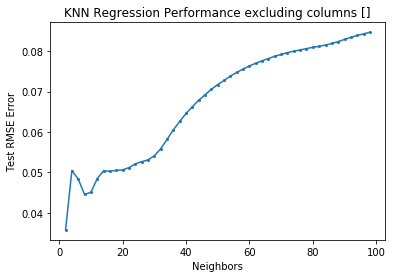

In [15]:
analyze_knn(range(2,100,2))

In [16]:
analyze_knn(range(2,100,2),['Week #','File Name'])

KeyError: 'File Name'

In [ ]:
workflows = list(set(dataset['Work-Flow-ID'].values))
workflow_datasets=[dataset.loc[dataset['Work-Flow-ID'] == x] for x in  workflows]
workflow_datasets_xy = [getX_Y_from_dataset(d) for d in workflow_datasets] 
workflow_datasets_xy_oh = [(one_hot_encode(x[0]),x[1]) for x in workflow_datasets_xy]

### Part 2d

In [ ]:
workflow_datasets_xy_oh = [(scalar_encode(x[0]),x[1]) for x in workflow_datasets_xy]

In [ ]:
def plot_graph(x,y,xlabel,ylabel,title):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.scatter(x, y, color='blue', lw=1, label=y,s=3)
    #plt.plot([y.min(), y.max()], [0,0], 'k--', lw=4)
    plt.show()

In [ ]:
def plot_graph_time(y1,y2,y1label,y2label,ylabel,title):
    plt.title(title)
    plt.scatter(np.arange(y1.shape[0]), y1, color='blue', label=y1label,s=3)
    plt.scatter(np.arange(y1.shape[0]), y2, color='red', label=y2label,s=3)
    plt.xlabel('Time')
    plt.ylabel(ylabel)
    plt.legend(loc='upper left')
    plt.show()

### 2d (i)

In [ ]:
def analyse_lin_reg_separate(plots=False):
    i = 0
    for x in workflow_datasets_xy_oh:
        print(workflows[i])
        i+=1
        regressor = LinearRegression()
        avg_tr,avg_ts,bestModel = perform_10fold(x[0],x[1],regressor)
        print("------------------------------")
        print("Average Training RMSE : ",avg_tr)
        print("Average Test RMSE : ",avg_ts)
        predicted = bestModel.predict(x[0])
        if(plots):
            plot_graph(x[1],predicted,"Actual","Fitted","Fitted vs Actual")
            plot_graph_time(x[1],predicted,"Actual","Fitted","Actual and Fitted values","Actual and Fitted values over time")
            plot_graph(predicted,x[1]-predicted,"Fitted","Residual","Residual vs Fitted")
            plot_graph_time(x[1]-predicted,predicted,"Residual","Fitted","Residual and Fitted values","Residual and Fitted values over time")


In [ ]:
def analyse_poly_lin_reg_separate(plots=False,poly_degrees = []):
    i = 0
    test_rm = defaultdict(list)
    train_rm= defaultdict(list)
    best_deg_map = {}
    for x in workflow_datasets_xy_oh:
        print("****************************")
        print(workflows[i])        
        best_ts = 10000
        best_model = None
        best_deg = -1
        best_poly = None
        for deg in poly_degrees:
            regressor = LinearRegression()
            poly = PolynomialFeatures(deg)
            x_ = poly.fit_transform(x[0])
            avg_tr,avg_ts,bestModel = perform_10fold(x_,x[1],regressor)
            test_rm[workflows[i]].append(avg_ts)
            train_rm[workflows[i]].append(avg_ts)
            print("average Training RMSE : ",avg_tr)
            print("average Test RMSE : ",avg_ts)
            if(avg_ts<=best_ts):
                best_ts = avg_ts
                best_model = bestModel
                best_deg = deg
                best_poly = poly
                print('best so far',deg)
        x_tot = best_poly.transform(x[0])
        predicted = best_model.predict(x_tot)
        best_deg_map[workflows[i]]=best_deg
        if(plots):
            plot_graph(x[1],predicted,"Actual","Fitted",str(workflows[i])+" Fitted vs Actual")
            plot_graph_time(x[1],predicted,"Actual","Fitted","Actual and Fitted values",str(workflows[i])+" Actual and Fitted values over time")
            plot_graph(predicted,x[1]-predicted,"Fitted","Residual",str(workflows[i])+" Residual vs Fitted")
            plot_graph_time(x[1]-predicted,predicted,"Residual","Fitted","Residual and Fitted values",str(workflows[i])+" Residual and Fitted values over time")
        i+=1
    print(best_deg)
    for x in workflows:
        plt.plot(poly_degrees,test_rm[x], label = x, marker='.',markersize=4)
    plt.title('Avg Test RMSE Vs Polynomial Degree')
    plt.xlabel('Degree of Polynomial')
    plt.ylabel('Test RMSE')
    plt.legend()
    plt.show()
    for x in workflows:
        plt.plot(poly_degrees,train_rm[x], label = x, marker='.',markersize=4)
    plt.title('Avg Train RMSE Vs Polynomial Degree')
    plt.xlabel('Degree of Polynomial')
    plt.ylabel('Train RMSE')
    plt.legend()
    plt.show()
    
        
        

In [ ]:
analyse_poly_lin_reg_separate(poly_degrees=[2,3,4,5,6,7,8])